In [1]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
diabete_data <- read_csv("data/diabetes.csv") |>
                mutate(Outcome = as_factor(Outcome)) |>
                filter(Glucose != 0) |> 
                filter(BloodPressure != 0) |> 
                filter(SkinThickness != 0) |> 
                filter(Insulin != 0) |> 
                filter(BMI != 0) |> 
                filter(Age != 0) |> 
                filter(DiabetesPedigreeFunction != 0)
diabete_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
3,78,50,32,88,31.0,0.248,26,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,0
10,101,76,48,180,32.9,0.171,63,0
5,121,72,23,112,26.2,0.245,30,0


In [3]:
set.seed(2022)

obs_num_outcome <- diabete_data |>
                    group_by(Outcome) |>
                    summarize(num_obs = n())

obs_num_outcome

Outcome,num_obs
<fct>,<int>
0,262
1,130


In [4]:
set.seed(2022)

diabete_split <- initial_split(diabete_data, prop = 0.75, strata = Outcome)
diabete_train <- training(diabete_split)
diabete_test <- testing(diabete_split)

diabete_split
diabete_train
diabete_test

means_predictors <- diabete_train |>
    select(-Outcome) |>
    map_df(mean)

means_predictors

<Training/Testing/Total>
<293/99/392>

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,0
3,126,88,41,235,39.3,0.704,27,0
1,97,66,15,140,23.2,0.487,22,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,120,80,37,150,42.3,0.785,48,1
3,187,70,22,200,36.4,0.408,36,1
1,128,88,39,110,36.5,1.057,37,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,166,72,19,175,25.8,0.587,51,1
1,103,30,38,83,43.3,0.183,33,0
10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,102,44,20,94,30.8,0.400,26,0
1,109,58,18,116,28.5,0.219,22,0
0,181,88,44,510,43.3,0.222,26,1


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.34471,120.6519,70.88055,29.04778,149.6416,33.04403,0.5107099,30.69283


In [5]:
set.seed(2022)
diabete_vfold <- vfold_cv(diabete_train, v = 5, strata = Outcome)

In [6]:
knn_recipe <- recipe(Outcome ~ ., data = diabete_train) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

In [7]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

In [8]:
set.seed(2022)
knn_results <- workflow() |>
               add_recipe(knn_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = diabete_vfold, grid = 20) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               arrange(desc(mean))

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model03
4,accuracy,binary,0.7748393,5,0.02824656,Preprocessor1_Model04
9,accuracy,binary,0.7675959,5,0.02963416,Preprocessor1_Model08
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.7574245,5,0.02324299,Preprocessor1_Model11
1,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model01
2,accuracy,binary,0.7407598,5,0.02689972,Preprocessor1_Model02


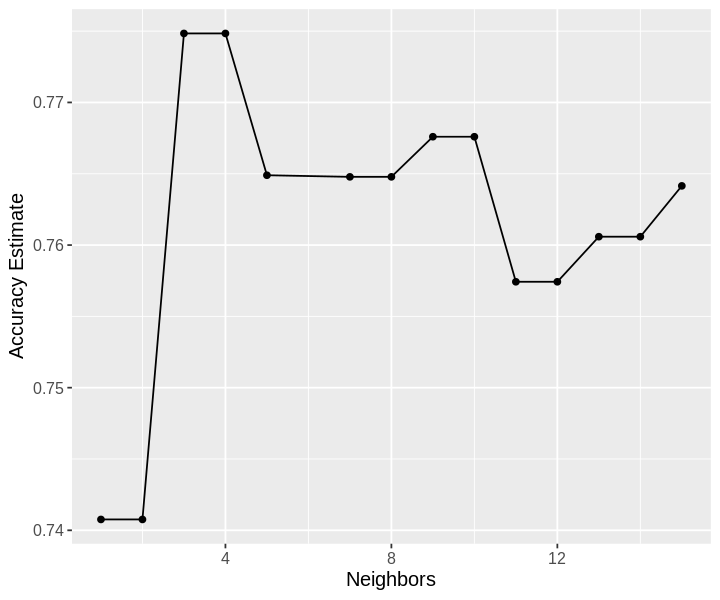

In [9]:
options(repr.plot.height = 5, repr.plot.width = 6)

cross_val_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    theme(text = element_text(size = 12))

cross_val_plot

In [10]:
diabete_recipe <- recipe(Outcome ~., data = diabete_train)

diabete_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
               set_engine("kknn") |>
               set_mode("classification")

diabete_fit <- workflow() |>
             add_recipe(diabete_recipe) |>
             add_model(diabete_spec) |>
             fit(data = diabete_train)

diabete_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2320819
Best kernel: rectangular
Best k: 15

In [11]:
set.seed(2022) 

diabete_predictions <- predict(diabete_fit, diabete_test) |>
                    bind_cols(diabete_test)

diabete_predictions

.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,5,166,72,19,175,25.8,0.587,51,1
0,1,103,30,38,83,43.3,0.183,33,0
0,10,125,70,26,115,31.1,0.205,41,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,3,102,44,20,94,30.8,0.400,26,0
0,1,109,58,18,116,28.5,0.219,22,0
1,0,181,88,44,510,43.3,0.222,26,1


In [12]:
diabete_metrics <- diabete_predictions |> 
                metrics(truth = Outcome, estimate = .pred_class) |>
                filter(.metric == "accuracy")

diabete_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7777778


In [13]:
mnist_conf_mat <- diabete_predictions |>
                    conf_mat(truth = Outcome, estimate = .pred_class)

mnist_conf_mat

          Truth
Prediction  0  1
         0 56 12
         1 10 21